# MURA Classification

#### Pre-trained Model: DenseNet


#### Specialised Models

In [2]:
EXTREMITY_NAME = 'WRIST'

# Data preparation

In [3]:
import pandas as pd

In [4]:
path = '/kaggle/input/MURA-v1.1'

#train
train_images = pd.DataFrame(pd.read_csv(path + '/train_image_paths.csv', header = None, names =['image_path']))
train_studies = pd.DataFrame(pd.read_csv(path +'/train_labeled_studies.csv', header= None, names=['study_path', 'label']))

#validation
test_images = pd.DataFrame(pd.read_csv(path + '/valid_image_paths.csv', header = None, names =['image_path']))
test_studies = pd.DataFrame(pd.read_csv(path + '/valid_labeled_studies.csv', header= None, names=['study_path', 'label']))

In [5]:
train_images['study_label'] = train_images['image_path'].str.rsplit('/', n=2, expand=True)[1].str.rsplit('_', n=1, expand=True)[1]

test_images['study_label'] = test_images['image_path'].str.rsplit('/', n=2, expand=True)[1].str.rsplit('_', n=1, expand=True)[1]

In [6]:
train_images['label'] = train_images['study_label'].map({'positive': 1, 'negative': 0})

test_images['label'] = test_images['study_label'].map({'positive': 1, 'negative': 0})

In [7]:
train_images['XR'] = train_images['image_path'].str.rsplit('/', n=5, expand=True)[2]
test_images['XR'] = test_images['image_path'].str.rsplit('/', n=5, expand=True)[2]

# EDA

In [8]:
train_images['label'].value_counts()

label
0    21935
1    14873
Name: count, dtype: int64

In [9]:
prefix = '/kaggle/input/'

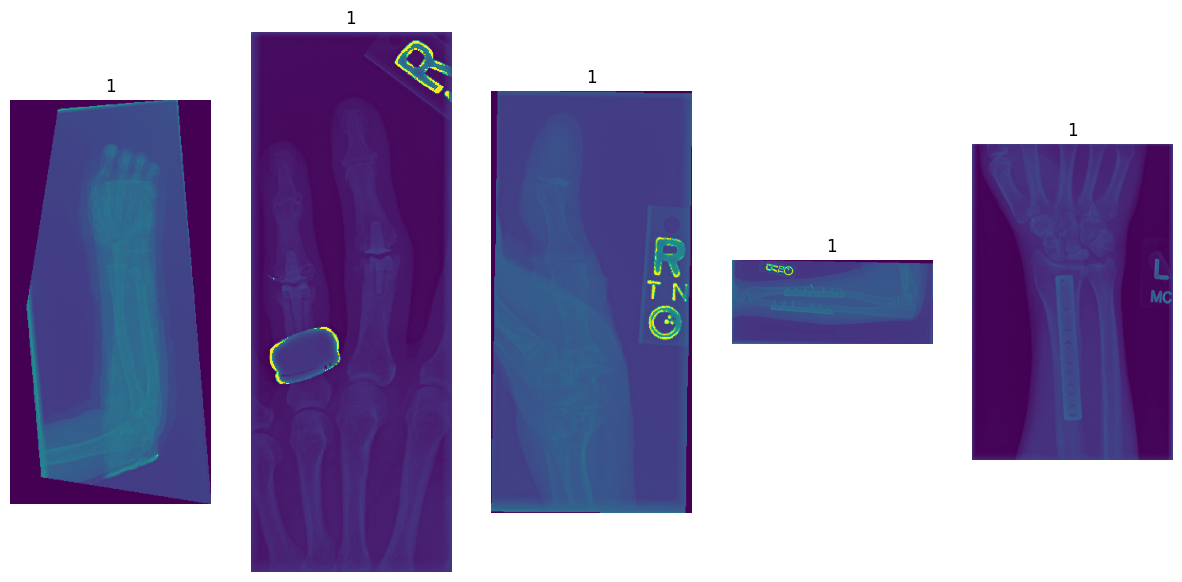

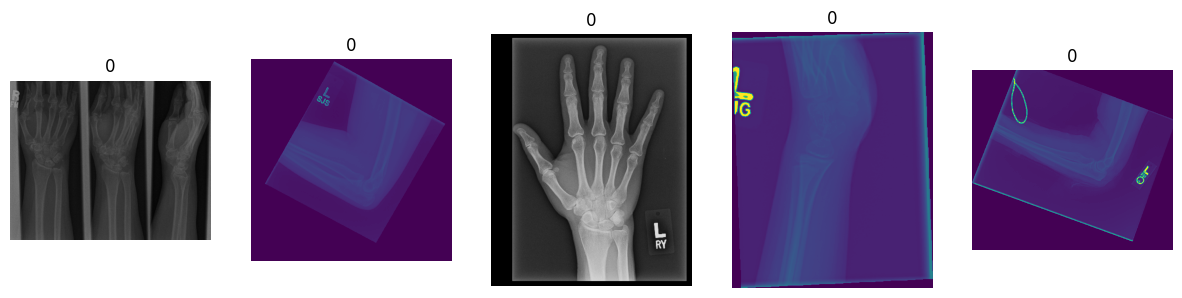

In [10]:
import matplotlib.pyplot as plt
import random
from PIL import Image

def plot_random_images(df, label, n=5):
    images = df[df['label'] == label]['image_path'].sample(n)
    plt.figure(figsize=(15, 15))
    for i, path in enumerate(images):
        img = Image.open(prefix + path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')
    plt.show()

for label in train_images['label'].unique():
    plot_random_images(train_images, label)


In [11]:
train_images['XR'].value_counts()

XR
XR_WRIST       9752
XR_SHOULDER    8379
XR_HAND        5543
XR_FINGER      5106
XR_ELBOW       4931
XR_FOREARM     1825
XR_HUMERUS     1272
Name: count, dtype: int64

In [12]:
train_images = train_images[train_images['XR'] == f"XR_{EXTREMITY_NAME}"] 

# Training

In [11]:
train_images['image_path'] = prefix + train_images['image_path']

In [ ]:
from sklearn.model_selection import train_test_split
train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)
print('Number of images in training set:', len(train_images))
print('Number of images in validation set:', len(val_images))
print('Number of images in test set:', len(test_images))

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch 

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize (for pre-trained models)
])

class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']


        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
batch_size = 32
dataset = ImageDataset(train_images, transform=transform)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) 

#val_images['image_path'] = prefix + val_images['image_path']
val_dataset = ImageDataset(val_images, transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)  # Adjust batch_size as needed

In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

model = models.densenet201(pretrained=True)


num_features = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5), 
    nn.Linear(512, 1)
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)


scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

model.to(device) 


In [ ]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()

In [ ]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Training Phase
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images = images.to('cuda')
            labels = labels.to('cuda').float()  # Ensure labels are float32 for BCEWithLogitsLoss
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images).squeeze(1)  # Model output shape: [batch_size]
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            
            # Calculate training accuracy
            predictions = torch.sigmoid(outputs) > 0.5  # Binary predictions
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)
        
        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = train_correct / train_total * 100  # Training accuracy in percentage
        train_loss.append(avg_train_loss)
        train_acc.append(train_accuracy)
        
        # Validation Phase
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images = images.to('cuda')
                labels = labels.to('cuda').float()
                
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                
                # Calculate validation accuracy
                predictions = torch.sigmoid(outputs) > 0.5
                val_correct += (predictions == labels).sum().item()
                val_total += labels.size(0)

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = val_correct / val_total * 100  # Validation accuracy in percentage
        val_loss.append(avg_val_loss)
        val_acc.append(val_accuracy)

        # Logging progress
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0  # Reset the counter if validation loss improves
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
            print("Validation loss improved. Saving the model...")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print("Early stopping triggered. Training stopped.")
            break
    
    return train_loss, train_acc, val_loss, val_acc


In [ ]:
# from sklearn.metrics import accuracy_score
# from tqdm import tqdm

# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
#     train_loss, val_loss, train_acc, val_acc = [], [], [], []
    
#     for epoch in range(num_epochs):
#         model.train()
#         running_train_loss = 0.0
#         train_correct = 0
#         train_total = 0
        
#         # Training Phase
#         for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
#             images = images.to('cuda')
#             labels = labels.to('cuda').float()  # Ensure labels are float32 for BCEWithLogitsLoss
            
#             optimizer.zero_grad()
            
#             # Forward pass
#             outputs = model(images).squeeze(1)  # Model output shape: [batch_size]
#             loss = criterion(outputs, labels)
            
#             # Backward pass and optimization
#             loss.backward()
#             optimizer.step()
            
#             running_train_loss += loss.item()
            
#             # Calculate training accuracy
#             predictions = torch.sigmoid(outputs) > 0.5  # Binary predictions
#             train_correct += (predictions == labels).sum().item()
#             train_total += labels.size(0)
        
#         avg_train_loss = running_train_loss / len(train_loader)
#         train_accuracy = train_correct / train_total * 100  # Training accuracy in percentage
#         train_loss.append(avg_train_loss)
#         train_acc.append(train_accuracy)
        
#         # Validation Phase
#         model.eval()
#         running_val_loss = 0.0
#         val_correct = 0
#         val_total = 0

#         with torch.no_grad():
#             for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
#                 images = images.to('cuda')
#                 labels = labels.to('cuda').float()
                
#                 outputs = model(images).squeeze(1)
#                 loss = criterion(outputs, labels)
#                 running_val_loss += loss.item()
                
#                 # Calculate validation accuracy
#                 predictions = torch.sigmoid(outputs) > 0.5
#                 val_correct += (predictions == labels).sum().item()
#                 val_total += labels.size(0)

#         avg_val_loss = running_val_loss / len(val_loader)
#         val_accuracy = val_correct / val_total * 100  # Validation accuracy in percentage
#         val_loss.append(avg_val_loss)
#         val_acc.append(val_accuracy)

#         # Logging progress
#         print(f"Epoch {epoch+1}/{num_epochs}, "
#               f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
#               f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
#     return train_loss, train_acc, val_loss, val_acc


In [ ]:
train_loss, train_acc, val_loss, val_acc = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=20, patience=2)

In [ ]:
import numpy as np
np.save('/kaggle/working/train_loss.npy', train_loss)
np.save('/kaggle/working/val_loss.npy', val_loss)
np.save('/kaggle/working/train_acc.npy', train_acc)
np.save('/kaggle/working/val_acc.npy', val_acc)


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
torch.save(model.state_dict(), '/kaggle/working/model_densenet.pth')
torch.save(model, '/kaggle/working/entire_model_densenet.pth')


# Evaluation

In [14]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze(1)
            probabilities = torch.sigmoid(outputs)
            predicted = (probabilities > 0.5).long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

In [ ]:
test_images['image_path'] = '/kaggle/input/' + test_images['image_path']

In [15]:
test_images = test_images[test_images['XR'] == f"XR_{EXTREMITY_NAME}"] 

In [ ]:

test_dataset = ImageDataset(test_images, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Evaluate after training
evaluate_model(model, test_dataloader)